In [ ]:
!pip install openai
!pip install anthropic
!pip install matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import json
from openai import OpenAI
import anthropic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

In [5]:
openai = OpenAI(api_key=OPENAI_API_KEY)
anthropic = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

In [29]:
JSON_schema = {
          "type": "object",
          "properties": {
            "appointment_date": {
              "type": "string",
              "format": "date",
              "pattern": "^\\d{4}-\\d{2}-\\d{2}$",
              "description": "Date of the appointment in yyyy-mm-dd format"
            },
            "appointment_time": {
              "type": "string",
              "pattern": "^\\d{2}:\\d{2}$",
              "description": "Time of the appointment in hh:mm format"
            },
            "chief_complaint": {
              "type": "string",
              "maxLength": 50,
              "description": "Chief complaint. Capitalize the first letter of the string"
            },
            "soap_subjective": {
              "type": "string",
              "description": "Subjective information from the patient. DO NOT include patient name or date of birth."
            },
            "soap_objective": {
              "type": "string",
              "description": "Objective observations and measurements. Narrative format or UNORDERED list. DO NOT include patient name or date of birth."
            },
            "soap_assessment": {
              "type": "string",
              "description": "Assessment and diagnosis. Narrative format or UNORDERED list. NO DIFFERENTIAL DIAGNOSIS in this field."
            },
            "soap_plan": {
              "type": "string",
              "description": "Plan for treatment and patient education. Narrative format or UNORDERED list."
            },
            "differential_diagnosis": {
              "type": "string",
              "description": "Differential diagnosis. Narrative format or UNORDERED list."
            },
            "patient_location": {
              "type": "string",
              "description": "Location of the patient (State/Province, e.g., 'Arizona'). Only include this key if the patient location is clearly mentioned in the transcript."
            }
          }
        }

In [30]:
system_content_string = f"""
You are a helpful, highly-trained medical assistant. Carefully review the following TRANSCRIPT and generate a clinical SOAP note as a JSON object.
Your answer MUST begin and end with curly brackets. Do not include any leading backticks or other markers. ALL LISTS SHOULD BE UNORDERED AND STYLED WITH A SIMPLE DASH. NO NUMBERED LISTS. Include as much specific information as possible from the transcript in the SOAP note. Be thorough! If you do not have the information required to provide a value in any of the fields, just return the JSON object WITHOUT those fields. Do NOT return a field with an empty string or an "unknown" value. For the differential_diagnosis field, generate a differential diagnosis along with possible alternative treatment options. Your complete answer MUST begin and end with curly brackets.
"""

In [14]:
transcript = """
This patient was seen on July 24th, 2024, time 1536. Patient's name, Josephina Martina. She has no known drug allergies. She's complaining of low back pain. Josephina is a however-year-old female who, who I'm sorry I didn't give you her date of birth date of birth is May 23 1971 Josephina is a however year old female and called today complaining of having sciatic pain since November. She states that she was and has been to physical therapy she was doing better however it has worsened recently causing her to have left left-sided sciatic pain radiating down her left leg she reports of pain as being constant she denies any red flags such as saddle anesthesia, loss of urine or bowel control, and she denies having any weakness to the extremity. prescribed physical therapy, but no other workup for her. She has not had an MRI of her lumbar spine. She is on tenazidine for migraine headaches, but is not on any medication for this. She calls today with an acute flare-up and is requesting to be treated for it until she can get in to see her primary care doctor she denies any abdominal pain dysuria or hematuria she sees she's otherwise healthy she has no known drug allergies and no significant medical problems except for the migraine headaches. Based on her symptomatology and the fact that she is young and otherwise healthy, I will treat her for acute sciatica with lumbar go, but I have recommended that she undergo an MRI of her lumbar spine if she has not had any imaging as she may have a ruptured disc, nerve impingement, or degenerative disc disease. Her diagnosis is acute lumbar go with left-sided sciatica the plan is I have prescribed a medull dose pack to be dispensed per pharmacist no refill flexor all 20 milligram tablets used to take one POB ID PRN muscle spasm and Vicodin 5-3, 25 milligrams. She used to take one to two POQ, four to six hours, PRN pain, dispense 20, no refill."""

In [15]:
user_content_string = f"""
Give me a thorough SOAP note from the following transcript. Return your response as a JSON object. /// TRANSCRIPT: {transcript} """

In [33]:
openai_models = ['gpt-3.5-turbo', 'gpt-4-turbo', 'gpt-4o', 'gpt-4o-mini']

In [34]:
openai_temperatures = [1, 0.7]

In [35]:
anthropic_models = ['claude-3-haiku-20240307', 'claude-3-5-sonnet-20240620', 'claude-3-opus-20240229']

In [36]:
anthropic_temperatures = [1, 0.7]

In [37]:
iterations = 10

In [13]:
model_pricing = {
    "gpt-4": {
        "input_token_cost": 0.03,
        "output_token_cost": 0.06
    },
    "gpt-4-turbo": {
        "input_token_cost": 0.01,
        "output_token_cost": 0.03
    },
    "gpt-4o": {
        "input_token_cost": 0.005,
        "output_token_cost": 0.015
    },
    "gpt-4o-mini": {
        "input_token_cost": 0.00015,
        "output_token_cost": 0.0006
    },
    "gpt-3.5-turbo": {
        "input_token_cost": 0.0005,
        "output_token_cost": 0.0015
    },
    "claude-3-haiku-20240307": {
        "input_token_cost": 0.00025,
        "output_token_cost": 0.00125
    },
    "claude-3-5-sonnet-20240620": {
        "input_token_cost": 0.003,
        "output_token_cost": 0.015
    },
    "claude-3-opus-20240229": {
        "input_token_cost": 0.015,
        "output_token_cost": 0.075
    }
}

In [41]:
def get_analysis_openai(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0):
    print(f"calling get_analysis_openai with model: {model}")
    start_time = time.time()

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content_string},
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            response_format={"type": "json_object"},
            tools=[{
                "type": "function",
                "function": {
                    "name": "JSON_soap_note",
                    "description":"Clinical SOAP note as a JSON object",
                    "parameters": JSON_schema
                }
            }],
            tool_choice={"type": "function", "function": {"name": "JSON_soap_note"}},
        )

        completion_string = response.choices[0].message.tool_calls[0].function.arguments
        usage = response.usage

        input_tokens = usage.prompt_tokens
        output_tokens = usage.completion_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': completion_string
        }

        # Parse completion string
        try:
            completion_data = json.loads(completion_string)
            response_data.update(completion_data)
        except json.JSONDecodeError:
            pass

        return response_data

    except Exception as e:
        print("Error getting OpenAI completion data:", e)
        return {'error': str(e)}

In [42]:
model='gpt-4o-mini'
temperature = 1
result = get_analysis_openai(system_content_string, user_content_string, model, temperature)
print(result)


calling get_analysis_openai with model: gpt-4o-mini
{'model': 'gpt-4o-mini', 'temperature': 1, 'input_tokens': 920, 'output_tokens': 297, 'input_cost': 0.00015, 'output_cost': 0.0006, 'prediction_cost': 0.0003162, 'prediction_time': 2.9919168949127197, 'completion_string': '{"appointment_date":"2024-07-24","appointment_time":"15:36","chief_complaint":"Low back pain","soap_subjective":"Josephina is a however-year-old female presenting with complaints of left-sided sciatic pain radiating down her left leg, which has worsened since November. She has been to physical therapy and was doing better, but reports constant pain now. She denies any red flags such as saddle anesthesia, loss of urine or bowel control, and weakness to the extremity. She has no abdominal pain, dysuria, or hematuria. She is otherwise healthy and on tenazidine for migraine headaches.","soap_objective":"- No known drug allergies\\n- No significant medical problems except migraine headaches\\n- No previous MRI of lumbar 

In [43]:
def get_analysis_anthropic(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0):
    print(f"calling get_analysis_anthropic with model: {model}")
    start_time = time.time()

    try:
        response = anthropic.messages.create(
            model=model,
            messages=[
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            system=system_content_string,
            max_tokens=4096,
            tool_choice={"type": "tool", "name":"JSON_soap_note"},
            tools=[{
                "name": "JSON_soap_note",
                "description":"Clinical SOAP note as a JSON object",
                "input_schema": JSON_schema
                }]
        )

        tool_use_block = response.content[0]

        soap_note = tool_use_block.input

        usage = response.usage
        input_tokens = usage.input_tokens
        output_tokens = usage.output_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': json.dumps(soap_note)
        }

        response_data.update(soap_note)


        return response_data

    except Exception as e:
        print("Error getting Anthropic completion data:", e)
        return {'error': str(e)}

In [44]:
model = 'claude-3-haiku-20240307'
temperature = 1

result = get_analysis_anthropic(system_content_string, user_content_string, model, temperature)

print(result)

calling get_analysis_anthropic with model: claude-3-haiku-20240307
{'model': 'claude-3-haiku-20240307', 'temperature': 1, 'input_tokens': 1460, 'output_tokens': 573, 'input_cost': 0.00025, 'output_cost': 0.00125, 'prediction_cost': 0.00108125, 'prediction_time': 3.445553779602051, 'completion_string': '{"appointment_date": "2024-07-24", "appointment_time": "15:36", "chief_complaint": "Low back pain", "differential_diagnosis": "- Lumbar radiculopathy due to disc herniation\\n- Degenerative disc disease\\n- Piriformis syndrome\\n- Lumbar spinal stenosis", "patient_location": "Unknown", "soap_assessment": "Acute lumbar radiculopathy with left-sided sciatica, likely due to a ruptured or herniated disc. Recommended MRI of the lumbar spine to evaluate for nerve impingement or degenerative disc disease.", "soap_objective": "- 42-year-old female\\n- Complaining of constant left-sided low back and leg pain since November\\n- Denies red flags such as saddle anesthesia, loss of bowel/bladder cont

In [ ]:
results_anthropic = []

for model in anthropic_models:
    for temperature in anthropic_temperatures:
        for _ in range(iterations):
            result = get_analysis_anthropic(system_content_string, user_content_string, model, temperature)
            if result:
                results_anthropic.append(result)

# Convert results to a DataFrame
df_results_anthropic = pd.DataFrame(results_anthropic)

# Save to csv
if os.path.exists('results-anthropic.csv'):
    df_results_anthropic.to_csv('results-anthropic.csv', mode='a', header=False, index=False)
else:
    df_results_anthropic.to_csv('results-anthropic.csv', index=False)

In [ ]:
results_openai = []

for model in openai_models:
    for temperature in openai_temperatures:
        for _ in range(iterations):
            result = get_analysis_openai(system_content_string, user_content_string, model, temperature)
            if result:
                results_openai.append(result)

# Convert results to a DataFrame
df_results_openai = pd.DataFrame(results_openai)

# Save to csv
if os.path.exists('results-openai.csv'):
    df_results_openai.to_csv('results-openai.csv', mode='a', header=False, index=False)
else:
    df_results_openai.to_csv('results-openai.csv', index=False)


## **RESULTS ANALYSIS**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/soapnotescribe/combined-results.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Analysis: Prediction Cost**

In [6]:
avg_cost = df.groupby('model')['prediction_cost'].mean().reset_index(name='avg')

grouped_cost = df.groupby('model')['prediction_cost'].agg(['min', 'max']).reset_index()
grouped_cost = pd.merge(grouped_cost, avg_cost, left_on='model', right_on='model')

grouped_cost = grouped_cost.sort_values(by='avg', ascending=True)

print(grouped_cost)

                        model       min       max       avg
6                 gpt-4o-mini  0.000318  0.000402  0.000358
3               gpt-3.5-turbo  0.000847  0.001032  0.000936
1     claude-3-haiku-20240307  0.000951  0.001081  0.001004
5                      gpt-4o  0.008860  0.010990  0.009821
0  claude-3-5-sonnet-20240620  0.012213  0.014403  0.013255
4                 gpt-4-turbo  0.018320  0.022490  0.020131
2      claude-3-opus-20240229  0.057090  0.072765  0.061650


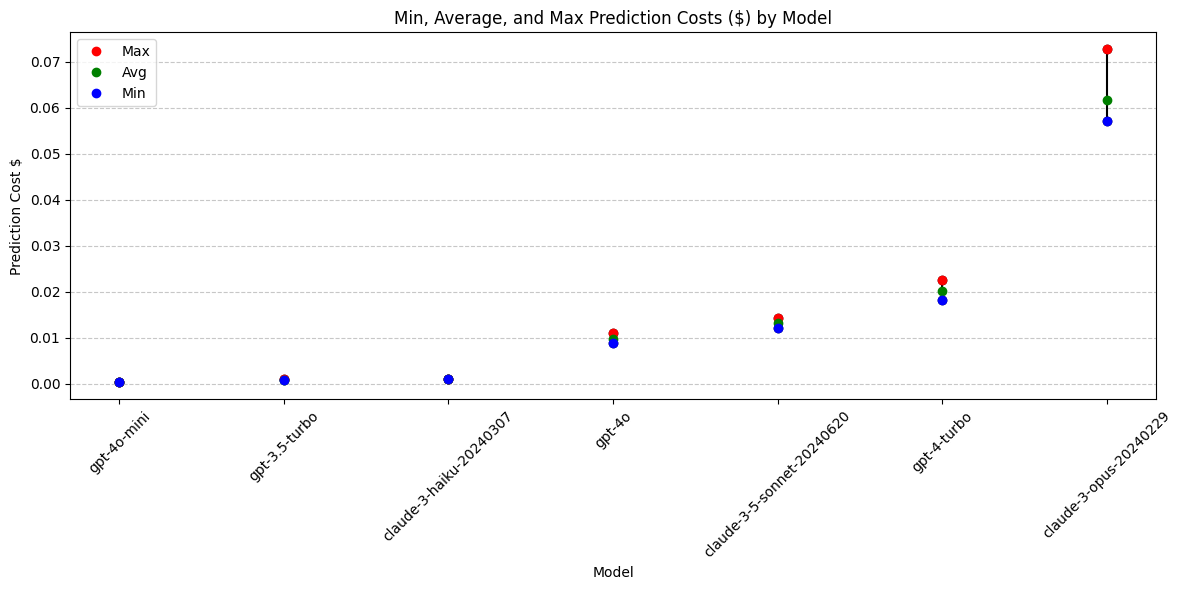

In [7]:
plt.figure(figsize=(12, 6))

for i, row in grouped_cost.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Cost $')
plt.title('Min, Average, and Max Prediction Costs ($) by Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Prediction Cost with Model Temperature**

What impact does changing the temperature have on cost?

Lower temp value = more deterministic output


In [8]:
# Calculate average cost, grouping by both model and temperature
avg_cost = df.groupby(['model', 'temperature'])['prediction_cost'].mean().reset_index(name='avg')

# Calculate min and max costs, grouping by both model and temperature
grouped_cost = df.groupby(['model', 'temperature'])['prediction_cost'].agg(['min', 'max']).reset_index()

# Merge the grouped cost with the average cost
grouped_cost = pd.merge(grouped_cost, avg_cost, on=['model', 'temperature'])

# Append temperature to the model name
grouped_cost['model'] = grouped_cost['model'] + ' (T=' + grouped_cost['temperature'].astype(str) + ')'

grouped_cost = grouped_cost.drop(columns = ['temperature'])

# Sort the DataFrame by avg cost in ascending order
grouped_cost = grouped_cost.sort_values(by='avg', ascending=True)

print(grouped_cost)


                                 model       min       max       avg
13                 gpt-4o-mini (T=1.0)  0.000338  0.000402  0.000357
12                 gpt-4o-mini (T=0.7)  0.000318  0.000396  0.000359
7                gpt-3.5-turbo (T=1.0)  0.000847  0.001003  0.000934
6                gpt-3.5-turbo (T=0.7)  0.000862  0.001032  0.000938
2      claude-3-haiku-20240307 (T=0.7)  0.000951  0.001081  0.000995
3      claude-3-haiku-20240307 (T=1.0)  0.000960  0.001058  0.001013
10                      gpt-4o (T=0.7)  0.008860  0.010990  0.009725
11                      gpt-4o (T=1.0)  0.009445  0.010720  0.009916
1   claude-3-5-sonnet-20240620 (T=1.0)  0.012213  0.014403  0.013208
0   claude-3-5-sonnet-20240620 (T=0.7)  0.012303  0.014178  0.013302
9                  gpt-4-turbo (T=1.0)  0.018320  0.021290  0.020021
8                  gpt-4-turbo (T=0.7)  0.018410  0.022490  0.020240
5       claude-3-opus-20240229 (T=1.0)  0.057915  0.066465  0.061282
4       claude-3-opus-20240229 (T=

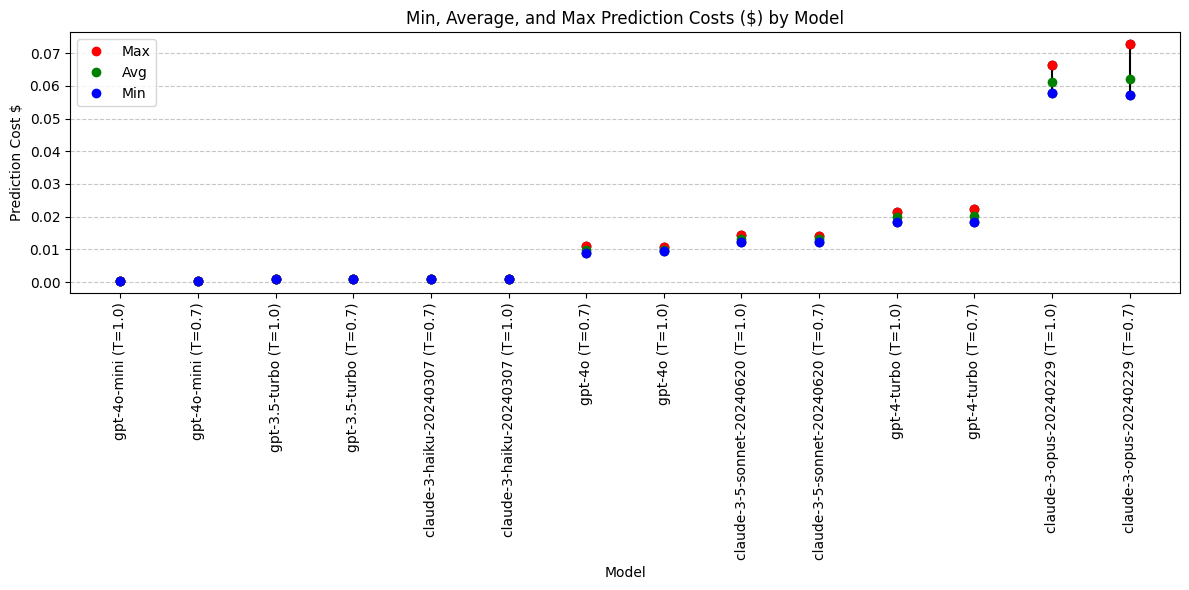

In [9]:
plt.figure(figsize=(12, 6))

for i, row in grouped_cost.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Cost $')
plt.title('Min, Average, and Max Prediction Costs ($) by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Conclusions: Prediction Cost**

Adjusting the temperature between 0.7 and 1.0 does not lead to a significant or consistent change in output length, nor does it introduce greater variability.

Four pricing tiers

Lowest:
- gpt-4o-mini
- gpt-3.5-turbo
- claude-3-haiku

Medium:
- gpt-4o
- claude-3.5-sonnet

High:
- gpt-4-turbo

Highest:
- claude-3-opus

Cost conclusions:
Claude-3-opus is an outlier in high cost. Widest cost range (highly variable output length). Lower temperature is more deterministic on this model, but the output length is even more varied at 0.7 than 1.0.

Models with pricing preference:
- gpt-4o-mini
- gpt-3.5-turbo
- claude-3-haiku

### **Analysis: Prediction Time**

In [10]:
avg_time = df.groupby('model')['prediction_time'].mean().reset_index(name='avg_time')

grouped_time = df.groupby('model')['prediction_time'].agg(['min', 'max']).reset_index()
grouped_time = pd.merge(grouped_time, avg_time, left_on='model', right_on='model')

grouped_time = grouped_time.sort_values(by='avg_time', ascending=True)

print(grouped_time)

                        model        min        max   avg_time
3               gpt-3.5-turbo   2.403372   4.903928   3.326057
1     claude-3-haiku-20240307   2.904863   3.945817   3.482712
6                 gpt-4o-mini   2.723844   5.356143   3.798611
5                      gpt-4o   3.496561   9.293203   4.771959
0  claude-3-5-sonnet-20240620   6.731199  10.581660   8.532432
4                 gpt-4-turbo   8.035556  18.641133  12.851380
2      claude-3-opus-20240229  17.476052  24.618349  20.815876


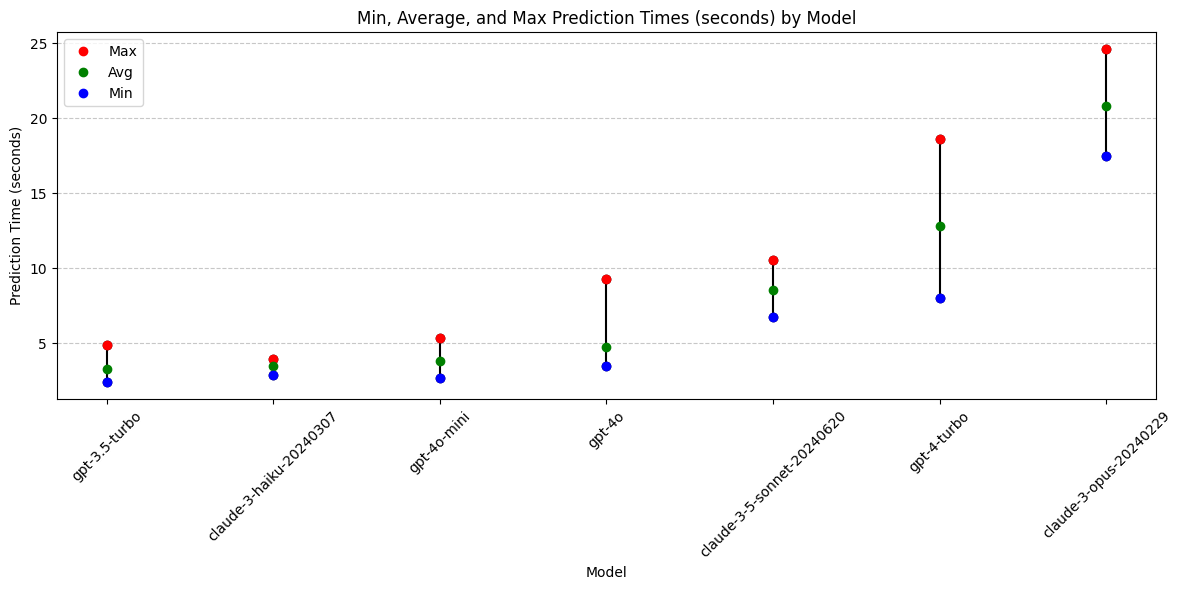

In [11]:
plt.figure(figsize=(12, 6))

for i, row in grouped_time.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_time'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Time (seconds)')
plt.title('Min, Average, and Max Prediction Times (seconds) by Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Conclusions: Prediction Time**
- Claude-3-opus and gpt-4-turbo are highly variable and both take the longest.

Models with prediction time preference:
- gpt-4o-mini
- gpt-3.5-turbo
- claude-3-haiku

### **Analysis: Output Tokens**

In [12]:
avg_output_tokens = df.groupby('model')['output_tokens'].mean().reset_index(name='avg_output')

grouped_output = df.groupby('model')['output_tokens'].agg(['min', 'max']).reset_index()
grouped_output = pd.merge(grouped_output, avg_output_tokens, left_on='model', right_on='model')

grouped_output = grouped_output.sort_values(by='avg_output', ascending=True)

print(grouped_output)

                        model  min  max  avg_output
3               gpt-3.5-turbo  253  376      312.35
5                      gpt-4o  284  426      348.05
4                 gpt-4-turbo  299  438      359.35
6                 gpt-4o-mini  300  440      367.20
1     claude-3-haiku-20240307  469  573      511.10
2      claude-3-opus-20240229  481  690      541.80
0  claude-3-5-sonnet-20240620  538  684      607.45


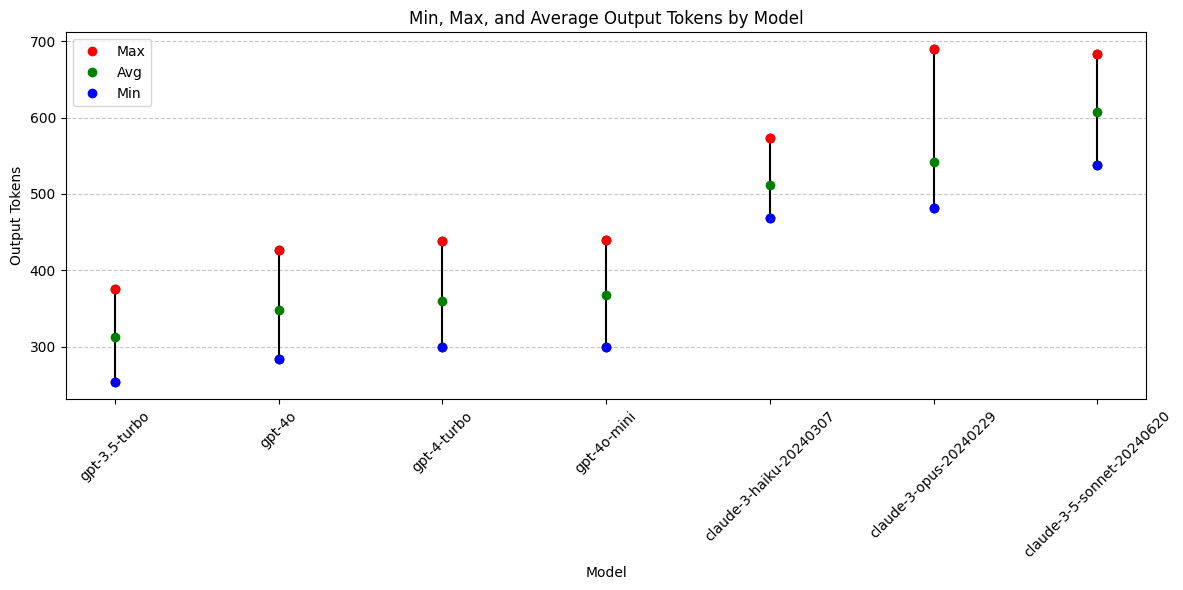

In [13]:
plt.figure(figsize=(12, 6))

for i, row in grouped_output.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_output'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Output Tokens')
plt.title('Min, Max, and Average Output Tokens by Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Output Tokens with Model Temperature**

What impact does changing the temperature have on output tokens?

Lower temp value = more deterministic output

In [14]:
avg_output_tokens = df.groupby(['model', 'temperature'])['output_tokens'].mean().reset_index(name='avg_output')

grouped_output = df.groupby(['model', 'temperature'])['output_tokens'].agg(['min', 'max']).reset_index()
grouped_output = pd.merge(grouped_output, avg_output_tokens, on=['model', 'temperature'])

grouped_output['model'] = grouped_output['model'] + ' (T=' + grouped_output['temperature'].astype(str) + ')'

grouped_output = grouped_output.drop(columns = ['temperature'])

grouped_output = grouped_output.sort_values(by='avg_output', ascending=True)

print(grouped_output)

                                 model  min  max  avg_output
7                gpt-3.5-turbo (T=1.0)  253  357       311.2
6                gpt-3.5-turbo (T=0.7)  263  376       313.5
10                      gpt-4o (T=0.7)  284  426       341.7
11                      gpt-4o (T=1.0)  323  408       354.4
9                  gpt-4-turbo (T=1.0)  299  398       355.7
8                  gpt-4-turbo (T=0.7)  302  438       363.0
13                 gpt-4o-mini (T=1.0)  334  440       365.7
12                 gpt-4o-mini (T=0.7)  300  430       368.7
2      claude-3-haiku-20240307 (T=0.7)  469  573       504.0
3      claude-3-haiku-20240307 (T=1.0)  476  554       518.2
5       claude-3-opus-20240229 (T=1.0)  492  606       536.9
4       claude-3-opus-20240229 (T=0.7)  481  690       546.7
1   claude-3-5-sonnet-20240620 (T=1.0)  538  684       604.3
0   claude-3-5-sonnet-20240620 (T=0.7)  544  669       610.6


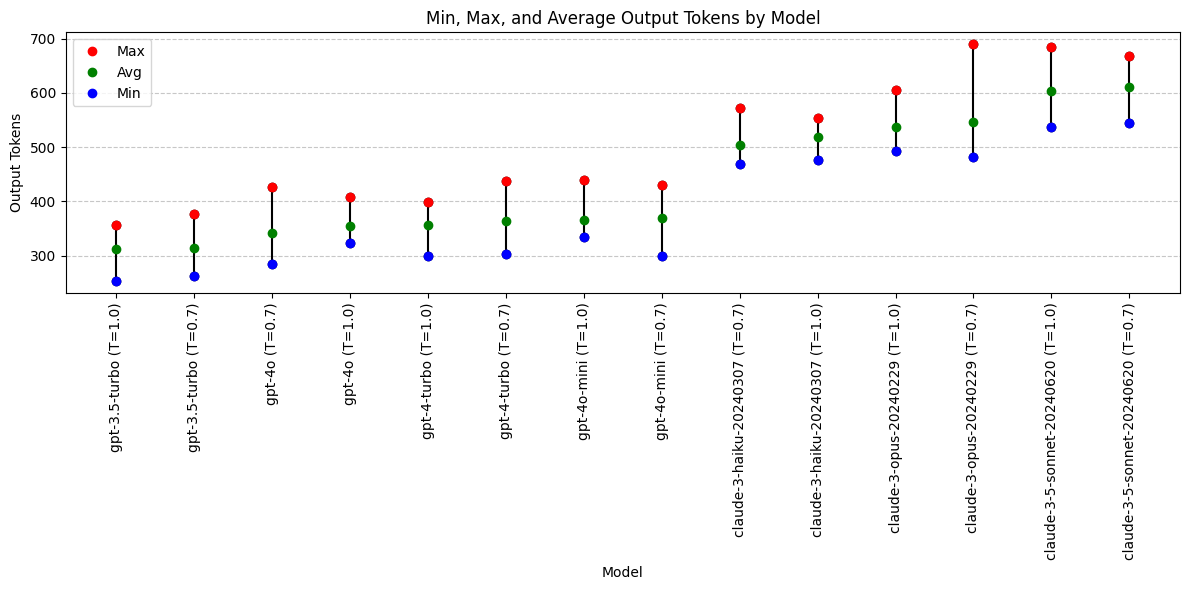

In [15]:
plt.figure(figsize=(12, 6))

for i, row in grouped_output.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_output'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Output Tokens')
plt.title('Min, Max, and Average Output Tokens by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Output Token Conclusions**
- Anthropic Claude models are all more verbose than OpenAI gpt models (given exact same prompt and JSON schema).
- Changing temperature does not have clear impact on output token length
- Why are Anthropic outputs longer? Inclusion of differential diagnosis or other content field?

Models with output token preference:
- Not applicable. Longer/shorter is not necessarily better.

### **Analysis: Differential Diagnosis**
- Was a Differential Diagnosis returned?
- How many Differential Diagnosis values included "alternative treatments" as requested in the system prompt?

In [16]:
# Function to calculate the length of differential diagnosis or zero if empty
def diagnosis_length(diagnosis: str):
    return len(diagnosis) if diagnosis else 0

In [17]:
df['differential_diagnosis'] = df['differential_diagnosis'].fillna('')

# Add a new column for the length of differential diagnosis
df['diff_diag_length'] = df['differential_diagnosis'].apply(diagnosis_length)

# Count the number of rows with a non-empty differential diagnosis
df['has_diff_diag'] = df['differential_diagnosis'].apply(lambda x: 1 if x else 0)

# Check if 'alternative' is in the differential diagnosis
df['has_alternative'] = df['differential_diagnosis'].apply(lambda x: 1 if 'alternative' in x.lower() else 0)

# Calculate the average length of differential diagnosis
avg_diff_length = df.groupby(['model', 'temperature'])['diff_diag_length'].mean().reset_index(name='avg_diff_length')

# Count the number of rows with a non-empty differential diagnosis
total_diff_diag = df.groupby(['model', 'temperature'])['has_diff_diag'].sum().reset_index(name='total_diff_diag')

# Count the number of rows with 'alternative' in the differential diagnosis
total_alternative = df.groupby(['model', 'temperature'])['has_alternative'].sum().reset_index(name='total_alternative')

# Merge the results
grouped_output = pd.merge(avg_diff_length, total_diff_diag, on=['model', 'temperature'])
grouped_output = pd.merge(grouped_output, total_alternative, on=['model', 'temperature'])

# Append temperature to the model name
grouped_output['model'] = grouped_output['model'] + ' (T=' + grouped_output['temperature'].astype(str) + ')'

# Drop the temperature column
grouped_output = grouped_output.drop(columns=['temperature'])

# Sort the DataFrame by avg_diff_length in ascending order
grouped_output = grouped_output.sort_values(by='avg_diff_length', ascending=True)

print(grouped_output)

                                 model  avg_diff_length  total_diff_diag  \
10                      gpt-4o (T=0.7)            143.6               10   
0   claude-3-5-sonnet-20240620 (T=0.7)            150.5               10   
11                      gpt-4o (T=1.0)            158.0               10   
2      claude-3-haiku-20240307 (T=0.7)            165.2               10   
6                gpt-3.5-turbo (T=0.7)            175.5                8   
3      claude-3-haiku-20240307 (T=1.0)            216.1               10   
7                gpt-3.5-turbo (T=1.0)            218.4                9   
12                 gpt-4o-mini (T=0.7)            219.1               10   
4       claude-3-opus-20240229 (T=0.7)            222.3               10   
5       claude-3-opus-20240229 (T=1.0)            223.9               10   
13                 gpt-4o-mini (T=1.0)            236.6               10   
1   claude-3-5-sonnet-20240620 (T=1.0)            251.7               10   
8           

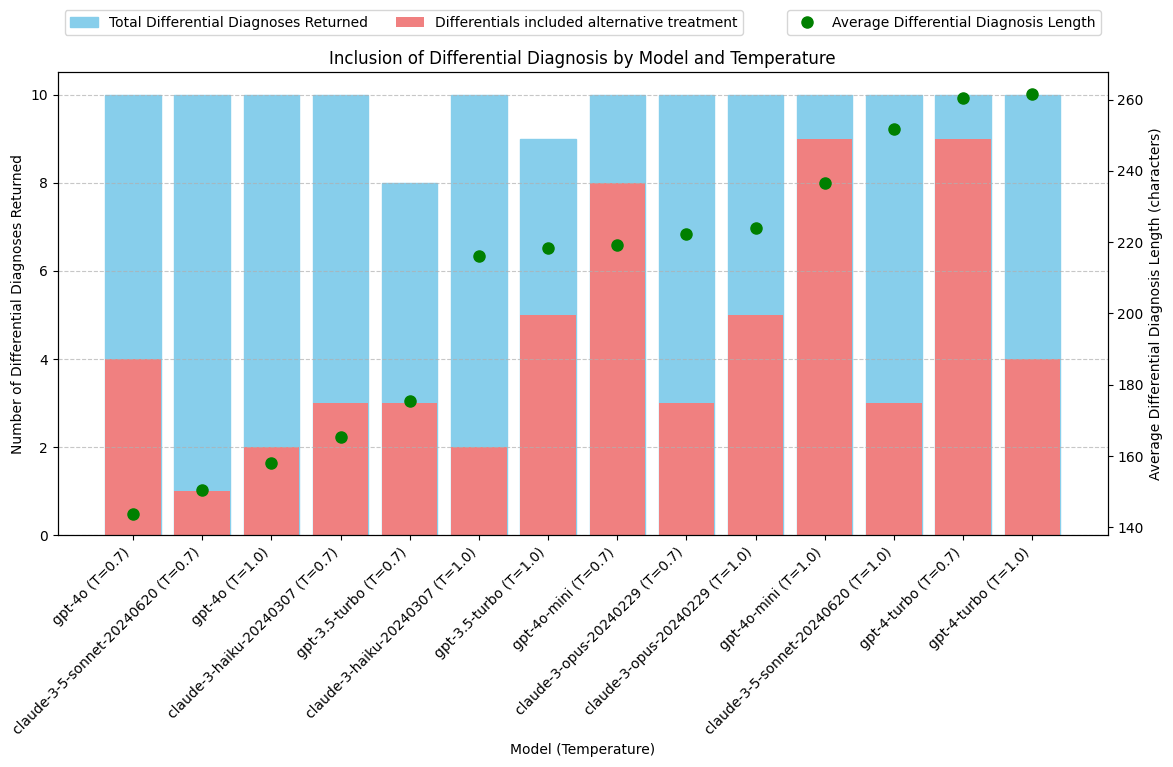

In [18]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for total differentials
bar1 = ax1.bar(grouped_output['model'], grouped_output['total_diff_diag'], label='Total Differential Diagnoses Returned', color='skyblue', edgecolor='skyblue')

# Bar chart for differentials that include "alternative"
bar2 = ax1.bar(grouped_output['model'], grouped_output['total_alternative'], label='Differentials included alternative treatment', color='lightcoral')

# Secondary y-axis for average differential diagnosis length
ax2 = ax1.twinx()
ax2.plot(grouped_output['model'], grouped_output['avg_diff_length'], color='green', marker='o', linestyle='', linewidth=2, markersize=8, label='Average Differential Diagnosis Length')

# Customizing the plot
ax1.set_xlabel('Model (Temperature)')
ax1.set_ylabel('Number of Differential Diagnoses Returned')
ax2.set_ylabel('Average Differential Diagnosis Length (characters)')
ax1.set_title('Inclusion of Differential Diagnosis by Model and Temperature')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=45, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15), ncol=1)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions: Differential Diagnosis**

- Results are highly varied across models. Difficult to draw conclusions about model capabilities. gpt-4-turbo may be better at writing a detailed differential diagnosis, but how would the other models perform if asked to do this task with more specific detail? gpt-4o-mini may be better at following system prompt instructions and including an alternative treatment, but how would the other models perform if this requirement was made more explicit? 
- While Claude models tend to return more total output tokens, this is not solely due to greater length or frequency of including a differential diagnosis.
- Update system prompt and JSON schema to better direct all models to include Differential Diagnosis with alternative treatment options.


### **Analysis: Fixing Transcription Errors**

The transcript includes the text "Vicodin 5-3, 25 milligrams" for when the speaker said "Vicodin five slash three twenty-five milligrams." This should have been transcribed as "Vicodin 5/325 milligrams."

The dosage of medications is typically written with a slash ("/") to clearly separate the amounts of each ingredient. "5" represents the amount of hydrocodone (usually in milligrams), and "325" represents the amount of acetaminophen (also in milligrams).
"Vicodin 5/325" means each tablet contains 5 mg of hydrocodone and 325 mg of acetaminophen.

The transcript also includes a spelling error related to a medication name: "flexor all 20 milligram tablets" should be "Flexeril 20 milligram tablets".

While this was not specifically requested in the prompt, some of the models caught these mistakes in the transcript and automatically fixed them in the response.

In [7]:
# Function to calculate whether the soap_plan includes the text 5/325
def check_formatting(soap_plan: str):
    return 1 if "5/325" in soap_plan else 0

In [8]:
# Function to calculate whether the soap_plan includes the text flexeril
def check_spelling(soap_plan: str):
    return 1 if "flexeril" in soap_plan.lower() else 0

In [9]:
# Add a new column to store whether soap_plan includes corrrect formatting of 5/325
df['corrected_formatting'] = df['soap_plan'].apply(check_formatting)

# Add a new column to store whether soap_plan includes corrected spelling of flexeril
df['corrected_spelling'] = df['soap_plan'].apply(check_spelling)

# Count the number of rows with correct formatting
total_formatted = df.groupby(['model', 'temperature'])['corrected_formatting'].sum().reset_index(name='total_formatted')

# Count the number of rows with correct spelling
total_spelling = df.groupby(['model', 'temperature'])['corrected_spelling'].sum().reset_index(name='total_spelling')

# Merge the results ()
grouped_output = pd.merge(total_formatted, total_spelling, on=['model', 'temperature'], how='inner')

# Append temperature to the model name
grouped_output['model'] = grouped_output['model'] + ' (T=' + grouped_output['temperature'].astype(str) + ')'

# Drop the temperature column
grouped_output = grouped_output.drop(columns=['temperature'])

# Sort the DataFrame by total_formatted in ascending order
grouped_output = grouped_output.sort_values(by='total_formatted', ascending=True)

print(grouped_output)

                                 model  total_formatted  total_spelling
0   claude-3-5-sonnet-20240620 (T=0.7)                0              10
1   claude-3-5-sonnet-20240620 (T=1.0)                0              10
2      claude-3-haiku-20240307 (T=0.7)                0              10
6                gpt-3.5-turbo (T=0.7)                0               3
8                  gpt-4-turbo (T=0.7)                0               4
12                 gpt-4o-mini (T=0.7)                0              10
13                 gpt-4o-mini (T=1.0)                0              10
7                gpt-3.5-turbo (T=1.0)                1               4
9                  gpt-4-turbo (T=1.0)                2               5
3      claude-3-haiku-20240307 (T=1.0)                3              10
4       claude-3-opus-20240229 (T=0.7)                3              10
5       claude-3-opus-20240229 (T=1.0)                3              10
11                      gpt-4o (T=1.0)                7         

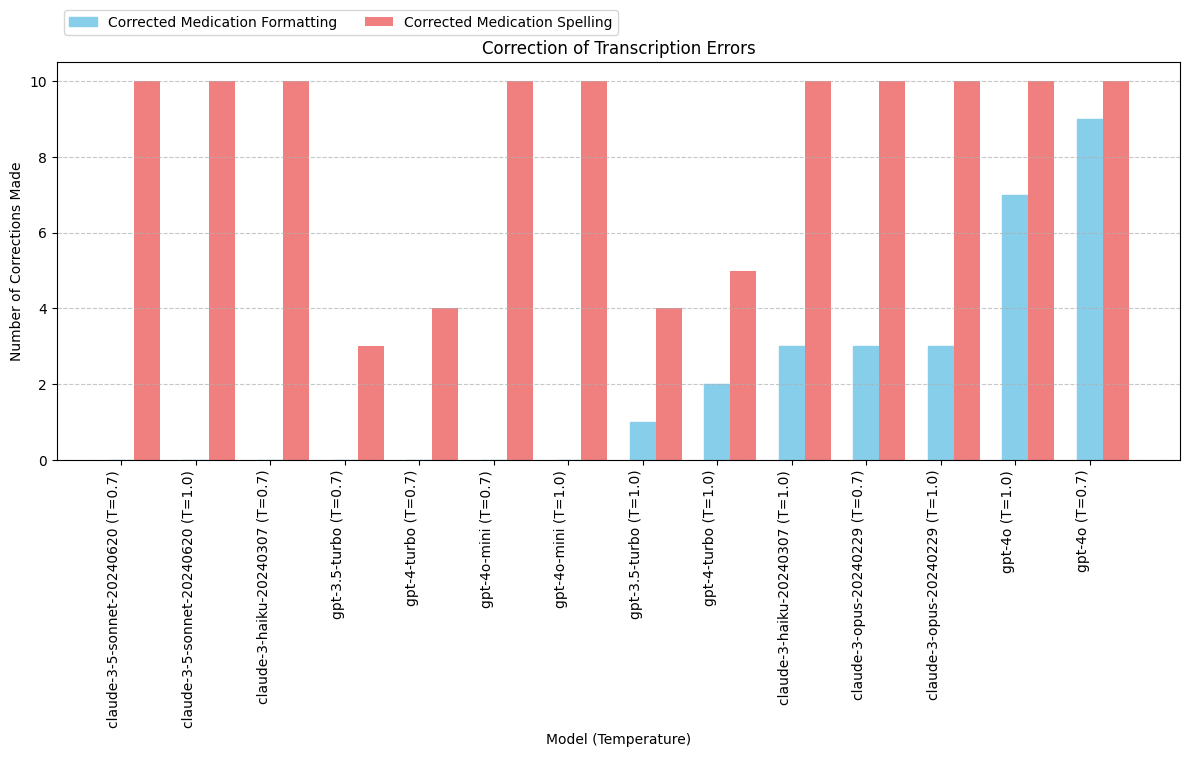

In [12]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35
opacity = 0.8

# Bar chart for total corrected values
bar1 = ax1.bar(grouped_output['model'], grouped_output['total_formatted'], width=bar_width, label='Corrected Medication Formatting', color='skyblue', edgecolor='skyblue')
bar2 = ax1.bar([x + bar_width for x in range(len(grouped_output['model']))], grouped_output['total_spelling'], width=bar_width, label='Corrected Medication Spelling', color='lightcoral')

# Customizing the plot
ax1.set_xlabel('Model (Temperature)')
ax1.set_ylabel('Number of Corrections Made')
ax1.set_title('Correction of Transcription Errors')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=90, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions: Fixing Transcription Errors**

- Results are highly varied across models. Difficult to draw conclusions about model capabilities. gpt-4o may be better at fixing transcriptions errors but this behavior was not specifically requested.
- Changing the temperature between 0.7 and 1.0 does not appear to have a direct impact on transcription error correction outcomes.
- Update system prompt and JSON schema to specifically request fixing medication transcription errors.



# PROMPT REVISION

- Update system_prompt and JSON_schema: Response MUST include Differential Diagnosis with an alternative treatment plan.
- Update system_prompt and JSON_schema: Transcripts are likely to include errors. Specify that you want the model to fix prescription names and formatting.

- Set minimum length for each response field to ensure longer responses? Could have negative consequences. Will this force the model to make something up if the information is not in the transcript? Decide to pass on this for now.

- Drop claude-3-opus: expensive.

Update JSON schema with more detailed differential diagnosis description:

In [17]:
JSON_schema_2 = {
          "type": "object",
          "properties": {
            "appointment_date": {
              "type": "string",
              "format": "date",
              "pattern": "^\\d{4}-\\d{2}-\\d{2}$",
              "description": "Date of the appointment in yyyy-mm-dd format"
            },
            "appointment_time": {
              "type": "string",
              "pattern": "^\\d{2}:\\d{2}$",
              "description": "Time of the appointment in hh:mm format"
            },
            "chief_complaint": {
              "type": "string",
              "description": "Chief complaint. Capitalize the first letter of the string"
            },
            "soap_subjective": {
              "type": "string",
              "minLength": 550,
              "description": "Subjective information from the patient. DO NOT include patient name or date of birth."
            },
            "soap_objective": {
              "type": "string",
              "minLength": 100,
              "description": "Objective observations and measurements. Narrative format or UNORDERED list. DO NOT include patient name or date of birth."
            },
            "soap_assessment": {
              "type": "string",
              "description": "Assessment and diagnosis. Narrative format or UNORDERED list. NO DIFFERENTIAL DIAGNOSIS in this field."
            },
            "soap_plan": {
              "type": "string",
              "minLength": 250,
              "description": "Plan for treatment and patient education. Narrative format or UNORDERED list. Be sure to correct spelling and formatting of medications."
            },
            "differential_diagnosis": {
              "type": "string",
              "minLength": 140,
              "description": "Differential diagnosis and alternative treatment plan. Narrative format or UNORDERED list. ALWAYS INCLUDE."
            },
            "patient_location": {
              "type": "string",
              "description": "Location of the patient (State/Province, e.g., 'Arizona'). Only include this key if the patient location is clearly mentioned in the transcript."
            }
          }
        }

Update system content string to specify differential diagnosis will be generated; medication spelling and formatting may need to be corrected.

In [18]:
system_content_string_2 = """
As a highly skilled medical assistant, your task is to meticulously review the provided TRANSCRIPT and craft a clinical SOAP note in the form of a JSON object. Please adhere strictly to the following guidelines:
- Ensure all lists within the SOAP note are unordered, formatted with a simple dash (-). Avoid using numbered lists.
- Incorporate as much detailed information as possible from the transcript into the SOAP note. Thoroughness is key!
- If certain information required for any fields is missing from the transcript, exclude those fields from the JSON object entirely. Do not include fields with empty strings or "unknown" values.
- The transcript may not explicitly mention differential diagnoses. As an expert, you are expected to formulate a differential diagnosis based on the transcript information. Always include a differential diagnosis along with alternative treatment recommendations in your SOAP note.
- Be vigilant for formatting and spelling errors in the transcript, particularly regarding prescription medications. Correct these errors accurately. Pay special attention to the spelling and formatting of any prescription medications mentioned.
Your expertise and attention to detail will ensure the generation of a comprehensive and accurate SOAP note.
"""

Create a new param to track prompt version updates:

In [32]:
prompt_version = 2

In [19]:
openai_models = ['gpt-3.5-turbo', 'gpt-4-turbo', 'gpt-4o', 'gpt-4o-mini']

In [20]:
openai_temperatures = [1, 0.7]

In [21]:
anthropic_models = ['claude-3-haiku-20240307', 'claude-3-5-sonnet-20240620']

In [22]:
anthropic_temperatures = [1, 0.7]

In [23]:
iterations = 10

Update model call to take prompt version param:

In [33]:
def get_analysis_openai(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0, prompt_version: int = 1):
    print(f"calling get_analysis_openai with model: {model}")
    start_time = time.time()

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_content_string},
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            response_format={"type": "json_object"},
            tools=[{
                "type": "function",
                "function": {
                    "name": "JSON_soap_note",
                    "description":"Clinical SOAP note as a JSON object",
                    "parameters": JSON_schema_2
                }
            }],
            tool_choice={"type": "function", "function": {"name": "JSON_soap_note"}},
        )

        completion_string = response.choices[0].message.tool_calls[0].function.arguments
        usage = response.usage

        input_tokens = usage.prompt_tokens
        output_tokens = usage.completion_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': completion_string,
            'prompt_version': prompt_version
        }

        # Parse completion string
        try:
            completion_data = json.loads(completion_string)
            response_data.update(completion_data)
        except json.JSONDecodeError:
            pass

        return response_data

    except Exception as e:
        print("Error getting OpenAI completion data:", e)
        return {'error': str(e)}

In [34]:
model='gpt-4o-mini'
temperature = 1
prompt_version = 2
result = get_analysis_openai(system_content_string_2, user_content_string, model, temperature, prompt_version)
print(result)


calling get_analysis_openai with model: gpt-4o-mini
{'model': 'gpt-4o-mini', 'temperature': 1, 'input_tokens': 1016, 'output_tokens': 652, 'input_cost': 0.00015, 'output_cost': 0.0006, 'prediction_cost': 0.0005436, 'prediction_time': 11.347606897354126, 'completion_string': '{"appointment_date":"2024-07-24","appointment_time":"15:36","chief_complaint":"Low back pain","soap_subjective":"Josephina Martina is a however-year-old female presenting with complaints of low back pain primarily associated with left-sided sciatica that has been ongoing since November. She reports that while she has been undergoing physical therapy, which initially improved her condition, her pain has recently worsened. The patient describes the pain as constant and radiating down her left leg. Importantly, she denies any alarming symptoms such as saddle anesthesia, loss of bowel or bladder control, and reports no weakness in her extremities. No history of abdominal pain, dysuria, or hematuria is noted. Josephina 

Update model call to take prompt version param:

In [36]:
def get_analysis_anthropic(system_content_string: str, user_content_string: str, model: str, temperature: float = 1.0, prompt_version: int = 1):
    print(f"calling get_analysis_anthropic with model: {model}")
    start_time = time.time()

    try:
        response = anthropic.messages.create(
            model=model,
            messages=[
                {"role": "user", "content": user_content_string},
            ],
            temperature=temperature,
            system=system_content_string,
            max_tokens=4096,
            tool_choice={"type": "tool", "name":"JSON_soap_note"},
            tools=[{
                "name": "JSON_soap_note",
                "description":"Clinical SOAP note as a JSON object",
                "input_schema": JSON_schema_2
                }]
        )

        tool_use_block = response.content[0]

        soap_note = tool_use_block.input

        usage = response.usage
        input_tokens = usage.input_tokens
        output_tokens = usage.output_tokens
        pricing = model_pricing[model]
        input_cost = pricing['input_token_cost']
        output_cost = pricing['output_token_cost']

        prediction_cost = ((input_tokens / 1000 * input_cost) + (output_tokens / 1000 * output_cost))
        prediction_time = time.time() - start_time


        response_data = {
            'model': model,
            'temperature': temperature,
            'input_tokens': input_tokens,
            'output_tokens': output_tokens,
            'input_cost': input_cost,
            'output_cost': output_cost,
            'prediction_cost': prediction_cost,
            'prediction_time': prediction_time,
            'completion_string': json.dumps(soap_note),
            'prompt_version': prompt_version
        }

        response_data.update(soap_note)


        return response_data

    except Exception as e:
        print("Error getting Anthropic completion data:", e)
        return {'error': str(e)}

In [27]:
model = 'claude-3-haiku-20240307'
temperature = 1

result = get_analysis_anthropic(system_content_string_2, user_content_string, model, temperature, prompt_version)

print(result)

calling get_analysis_anthropic with model: claude-3-haiku-20240307
{'model': 'claude-3-haiku-20240307', 'temperature': 1, 'input_tokens': 1565, 'output_tokens': 551, 'input_cost': 0.00025, 'output_cost': 0.00125, 'prediction_cost': 0.00108, 'prediction_time': 3.8441195487976074, 'completion_string': '{"appointment_date": "2024-07-24", "appointment_time": "15:36", "chief_complaint": "Low back pain", "soap_subjective": "Josephina Martina, a 53-year-old female, presented with complaints of left-sided sciatic pain radiating down her left leg since November. She states she has been undergoing physical therapy which helped, but the pain has recently worsened, causing constant pain. She denies any red flags such as saddle anesthesia, loss of urine or bowel control, and weakness in the extremity.", "soap_objective": "No further objective observations or measurements were provided in the transcript.", "soap_assessment": "Based on the patient\'s symptomatology and the fact that she is young and 

In [ ]:
results_anthropic = []

for model in anthropic_models:
    for temperature in anthropic_temperatures:
        for _ in range(iterations):
            result = get_analysis_anthropic(system_content_string_2, user_content_string, model, temperature, prompt_version)
            if result:
                results_anthropic.append(result)

# Convert results to a DataFrame
df_results_anthropic = pd.DataFrame(results_anthropic)

# Save to csv
if os.path.exists('results-anthropic.csv'):
    df_results_anthropic.to_csv('results-anthropic.csv', mode='a', header=False, index=False)
else:
    df_results_anthropic.to_csv('results-anthropic.csv', index=False)

In [ ]:
results_openai = []

for model in openai_models:
    for temperature in openai_temperatures:
        for _ in range(iterations):
            result = get_analysis_openai(system_content_string_2, user_content_string, model, temperature, prompt_version)
            if result:
                results_openai.append(result)

# Convert results to a DataFrame
df_results_openai = pd.DataFrame(results_openai)

# Save to csv
if os.path.exists('results-openai.csv'):
    df_results_openai.to_csv('results-openai.csv', mode='a', header=False, index=False)
else:
    df_results_openai.to_csv('results-openai.csv', index=False)


## **RESULTS ANALYSIS - UPDATED PROMPT - DROPPED CLAUDE 3.5 OPUS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/soapnotescribe/combined-results-prompt-update.csv')

### **Analysis: Prediction Cost with Updated Prompt**

What impact does the new prompt have on cost?


In [48]:
# Exclude claude-3-opus model
df = df.loc[df['model'] != 'claude-3-opus-20240229']

# Calculate average cost, grouping by both model and prompt_version
avg_cost = df.groupby(['model', 'prompt_version'])['prediction_cost'].mean().reset_index(name='avg')

# Calculate min and max costs, grouping by both model and prompt_version
grouped_cost = df.groupby(['model', 'prompt_version'])['prediction_cost'].agg(['min', 'max']).reset_index()

# Merge the grouped cost with the average cost
grouped_cost = pd.merge(grouped_cost, avg_cost, on=['model', 'prompt_version'])

# Append prompt_version to the model name
grouped_cost['model'] = grouped_cost['model'] + ' (V=' + grouped_cost['prompt_version'].astype(str) + ')'

grouped_cost = grouped_cost.drop(columns = ['prompt_version'])

# Sort the DataFrame by avg cost in ascending order
grouped_cost = grouped_cost.sort_values(by='avg', ascending=True)

print(grouped_cost)


                               model       min       max       avg
10                 gpt-4o-mini (V=1)  0.000318  0.000402  0.000358
11                 gpt-4o-mini (V=2)  0.000435  0.000607  0.000486
4                gpt-3.5-turbo (V=1)  0.000847  0.001032  0.000936
2      claude-3-haiku-20240307 (V=1)  0.000951  0.001081  0.001004
5                gpt-3.5-turbo (V=2)  0.000937  0.001129  0.001040
3      claude-3-haiku-20240307 (V=2)  0.000946  0.001259  0.001130
8                       gpt-4o (V=1)  0.008860  0.010990  0.009821
9                       gpt-4o (V=2)  0.010390  0.012520  0.011434
0   claude-3-5-sonnet-20240620 (V=1)  0.012213  0.014403  0.013255
1   claude-3-5-sonnet-20240620 (V=2)  0.017073  0.022578  0.019639
6                  gpt-4-turbo (V=1)  0.018320  0.022490  0.020131
7                  gpt-4-turbo (V=2)  0.019070  0.024710  0.021710


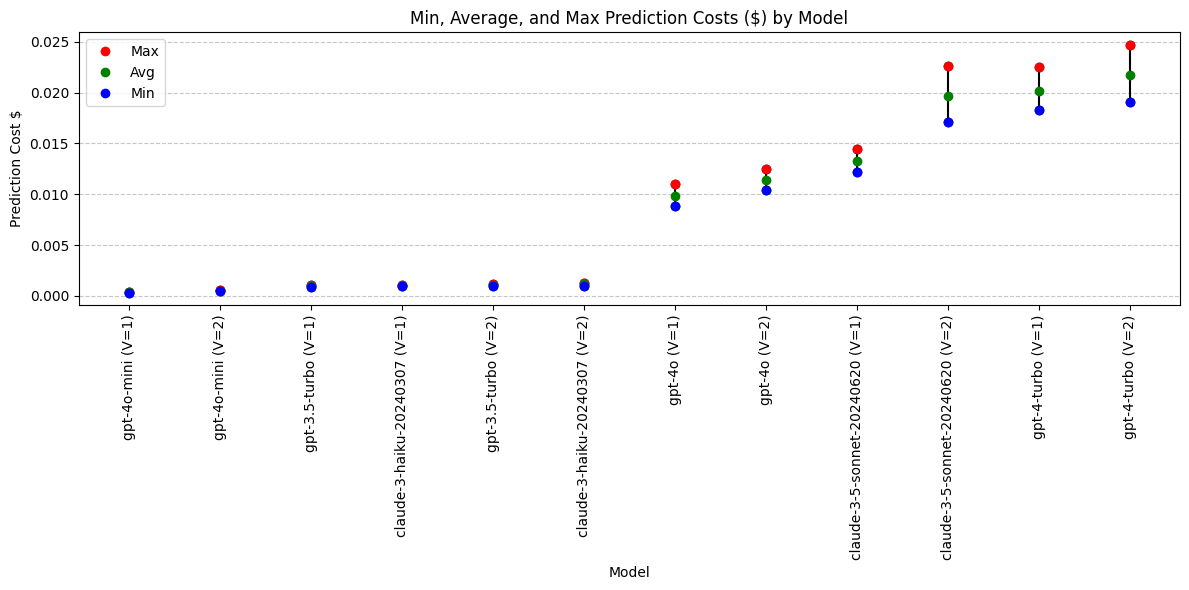

In [49]:
plt.figure(figsize=(12, 6))

for i, row in grouped_cost.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Cost $')
plt.title('Min, Average, and Max Prediction Costs ($) by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Conclusions: Prediction Cost**


Four pricing tiers - UPDATED

Low:
- gpt-4o-mini
- gpt-3.5-turbo
- claude-3-haiku

Medium:
- gpt-4o


High:
- claude-3.5-sonnet (moved up)
- gpt-4-turbo

Highest (excluded):
- claude-3-opus

Cost conclusions:
Claude-3-opus is an outlier in high cost. Claude 3.5 sonnet should be in the same pricing tier as gpt-4-turbo.

Models with pricing preference:
- gpt-4o-mini
- gpt-3.5-turbo
- claude-3-haiku

### **Analysis: Prediction Time**

In [51]:
# Exclude claude-3-opus model
df = df.loc[df['model'] != 'claude-3-opus-20240229']

avg_time = df.groupby('model')['prediction_time'].mean().reset_index(name='avg_time')

grouped_time = df.groupby('model')['prediction_time'].agg(['min', 'max']).reset_index()
grouped_time = pd.merge(grouped_time, avg_time, left_on='model', right_on='model')

grouped_time = grouped_time.sort_values(by='avg_time', ascending=True)

print(grouped_time)

                        model       min        max   avg_time
1     claude-3-haiku-20240307  2.904863   5.339926   3.794493
2               gpt-3.5-turbo  2.403372   5.995300   4.075451
4                      gpt-4o  3.496561  14.169378   6.490782
5                 gpt-4o-mini  2.723844  14.743062   6.679159
0  claude-3-5-sonnet-20240620  6.731199  18.393558  12.348582
3                 gpt-4-turbo  8.035556  20.452861  13.798264


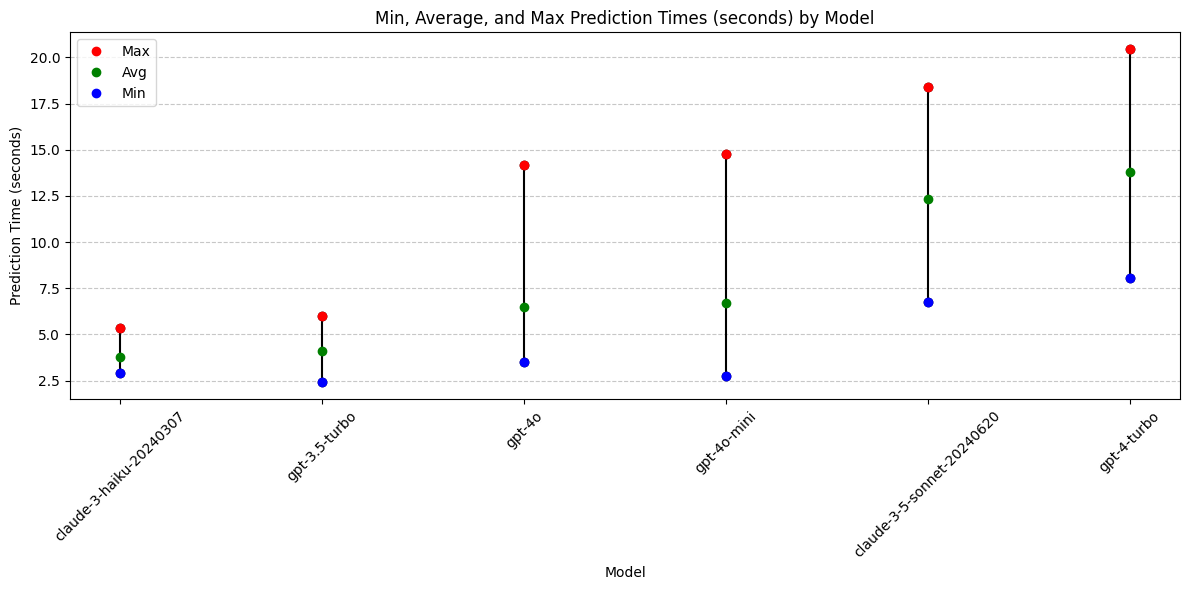

In [52]:
plt.figure(figsize=(12, 6))

for i, row in grouped_time.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_time'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Prediction Time (seconds)')
plt.title('Min, Average, and Max Prediction Times (seconds) by Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Conclusions: Prediction Time**
- Claude-3-haiku and gpt-3.5-turbo have quick and relatively consistent response times.

Models with prediction time preference:
- gpt-3.5-turbo
- claude-3-haiku

### **Analysis: Output Tokens with Prompt Versions**

What impact did changing the prompt have on output tokens?

V1 = first version
V2 = updated system_prompt and JSON_schema to demand Differential Diagnosis and corrected medication spelling/formatting

In [53]:
# Exclude claude-3-opus model
df = df.loc[df['model'] != 'claude-3-opus-20240229']

avg_output_tokens = df.groupby(['model', 'prompt_version'])['output_tokens'].mean().reset_index(name='avg_output')

grouped_output = df.groupby(['model', 'prompt_version'])['output_tokens'].agg(['min', 'max']).reset_index()
grouped_output = pd.merge(grouped_output, avg_output_tokens, on=['model', 'prompt_version'])

grouped_output = grouped_output.sort_values(by=['model', 'prompt_version'])


grouped_output['model'] = grouped_output['model'] + ' (V=' + grouped_output['prompt_version'].astype(str) + ')'

grouped_output = grouped_output.drop(columns = ['prompt_version'])

grouped_output = grouped_output.sort_values(by='avg_output')

print(grouped_output)

                               model  min   max  avg_output
4                gpt-3.5-turbo (V=1)  253   376      312.35
8                       gpt-4o (V=1)  284   426      348.05
5                gpt-3.5-turbo (V=2)  283   411      351.65
6                  gpt-4-turbo (V=1)  299   438      359.35
10                 gpt-4o-mini (V=1)  300   440      367.20
7                  gpt-4-turbo (V=2)  294   482      382.00
9                       gpt-4o (V=2)  354   496      423.60
2      claude-3-haiku-20240307 (V=1)  469   573      511.10
11                 gpt-4o-mini (V=2)  471   758      555.30
3      claude-3-haiku-20240307 (V=2)  444   694      590.85
0   claude-3-5-sonnet-20240620 (V=1)  538   684      607.45
1   claude-3-5-sonnet-20240620 (V=2)  841  1208     1012.05


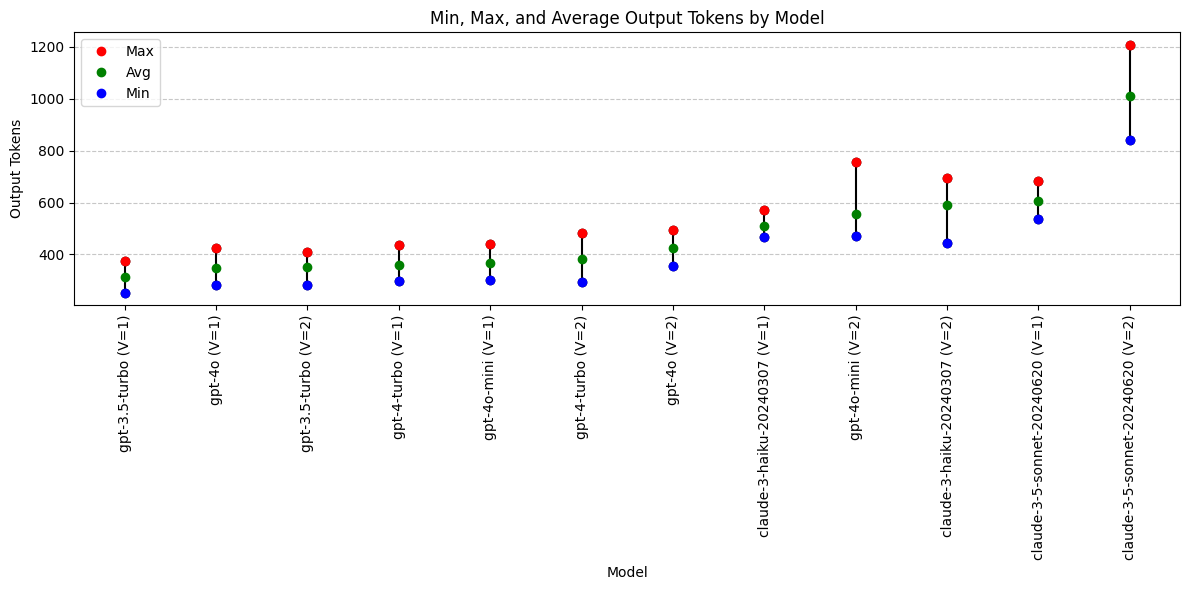

In [54]:
plt.figure(figsize=(12, 6))

for i, row in grouped_output.iterrows():
    plt.plot([row['model'], row['model']], [row['min'], row['max']], color='black', linestyle='-', marker='o')
    plt.plot(row['model'], row['max'], 'ro', label='Max' if i == 0 else "")
    plt.plot(row['model'], row['avg_output'], 'go', label='Avg' if i == 0 else "")
    plt.plot(row['model'], row['min'], 'bo', label='Min' if i == 0 else "")

plt.xlabel('Model')
plt.ylabel('Output Tokens')
plt.title('Min, Max, and Average Output Tokens by Model')
plt.xticks(rotation=90)
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Conclusions: Output Tokens**
- Anthropic's Claude models still generally produce more verbose outputs than OpenAI's GPT models, but the revised prompt has led to the gpt-4o-mini model achieving output lengths comparable to those of the Claude models.


Models with output token preference:
- Not applicable. Longer/shorter is not necessarily better.

### **Analysis: Differential Diagnosis**
- Was a Differential Diagnosis returned?
- How many Differential Diagnosis values included "alternative treatments" as requested in the system prompt?

In [55]:
# Function to calculate the length of differential diagnosis or zero if empty
def diagnosis_length(diagnosis: str):
    return len(diagnosis) if diagnosis else 0

In [57]:
# Exclude claude-3-opus model
df = df.loc[df['model'] != 'claude-3-opus-20240229']

df['differential_diagnosis'] = df['differential_diagnosis'].fillna('')

# Add a new column for the length of differential diagnosis
df['diff_diag_length'] = df['differential_diagnosis'].apply(diagnosis_length)

# Count the number of rows with a non-empty differential diagnosis
df['has_diff_diag'] = df['differential_diagnosis'].apply(lambda x: 1 if x else 0)

# Check if 'alternative' is in the differential diagnosis
df['has_alternative'] = df['differential_diagnosis'].apply(lambda x: 1 if 'alternative' in x.lower() else 0)

# Calculate the average length of differential diagnosis
avg_diff_length = df.groupby(['model', 'prompt_version'])['diff_diag_length'].mean().reset_index(name='avg_diff_length')

# Count the number of rows with a non-empty differential diagnosis
total_diff_diag = df.groupby(['model', 'prompt_version'])['has_diff_diag'].sum().reset_index(name='total_diff_diag')

# Count the number of rows with 'alternative' in the differential diagnosis
total_alternative = df.groupby(['model', 'prompt_version'])['has_alternative'].sum().reset_index(name='total_alternative')

# Merge the results
grouped_output = pd.merge(avg_diff_length, total_diff_diag, on=['model', 'prompt_version'])
grouped_output = pd.merge(grouped_output, total_alternative, on=['model', 'prompt_version'])

# Append temperature to the model name
grouped_output['model'] = grouped_output['model'] + ' (V=' + grouped_output['prompt_version'].astype(str) + ')'

# Drop the temperature column
grouped_output = grouped_output.drop(columns=['prompt_version'])

# Sort the DataFrame by avg_diff_length in ascending order
grouped_output = grouped_output.sort_values(by='avg_diff_length', ascending=True)

print(grouped_output)

                               model  avg_diff_length  total_diff_diag  \
8                       gpt-4o (V=1)           150.80               20   
7                  gpt-4-turbo (V=2)           155.65               20   
9                       gpt-4o (V=2)           157.80               20   
2      claude-3-haiku-20240307 (V=1)           190.65               20   
4                gpt-3.5-turbo (V=1)           196.95               17   
0   claude-3-5-sonnet-20240620 (V=1)           201.10               20   
10                 gpt-4o-mini (V=1)           227.85               20   
5                gpt-3.5-turbo (V=2)           244.80               20   
6                  gpt-4-turbo (V=1)           261.05               20   
3      claude-3-haiku-20240307 (V=2)           299.30               20   
11                 gpt-4o-mini (V=2)           376.10               20   
1   claude-3-5-sonnet-20240620 (V=2)          1307.85               20   

    total_alternative  
8            

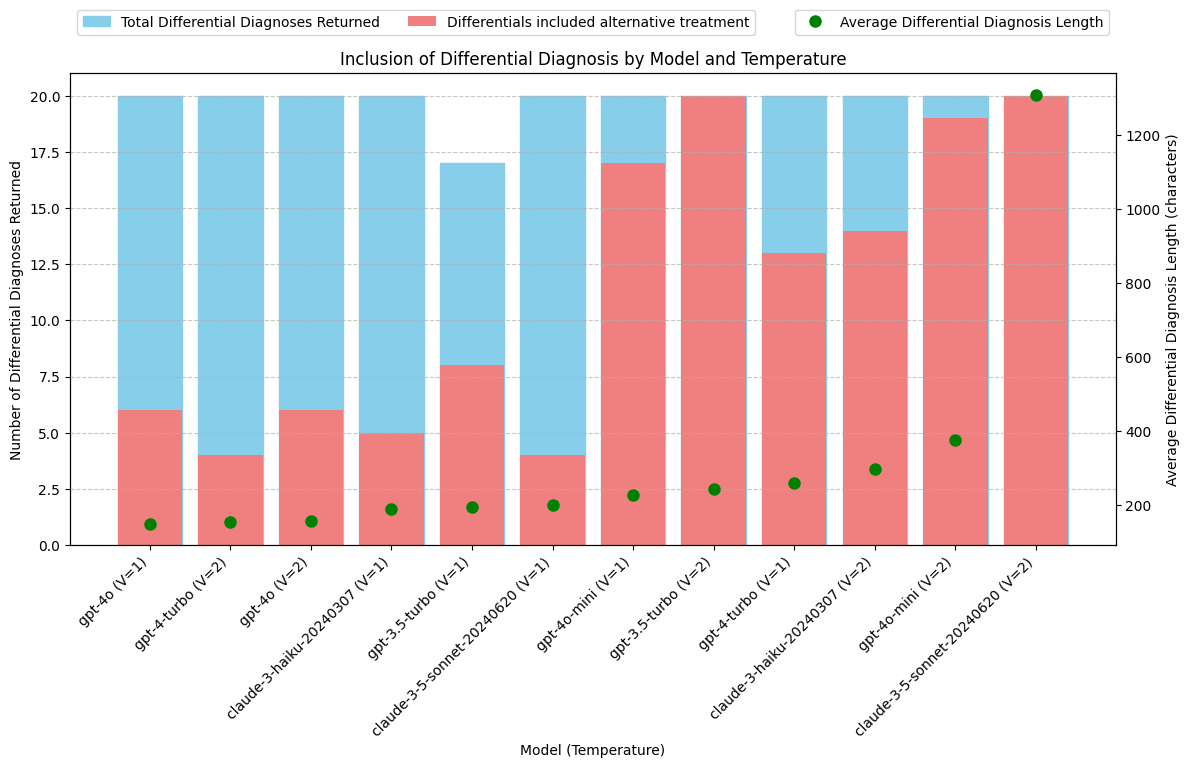

In [58]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar chart for total differentials
bar1 = ax1.bar(grouped_output['model'], grouped_output['total_diff_diag'], label='Total Differential Diagnoses Returned', color='skyblue', edgecolor='skyblue')

# Bar chart for differentials that include "alternative"
bar2 = ax1.bar(grouped_output['model'], grouped_output['total_alternative'], label='Differentials included alternative treatment', color='lightcoral')

# Secondary y-axis for average differential diagnosis length
ax2 = ax1.twinx()
ax2.plot(grouped_output['model'], grouped_output['avg_diff_length'], color='green', marker='o', linestyle='', linewidth=2, markersize=8, label='Average Differential Diagnosis Length')

# Customizing the plot
ax1.set_xlabel('Model (Temperature)')
ax1.set_ylabel('Number of Differential Diagnoses Returned')
ax2.set_ylabel('Average Differential Diagnosis Length (characters)')
ax1.set_title('Inclusion of Differential Diagnosis by Model and Temperature')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=45, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.15), ncol=1)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions: Differential Diagnosis**

- claude-3.5-sonnet with new prompt is an outlier with Differential Diagnosis output length 3x - 5x longer than other models.
- gpt-4o-mini and gpt-3.5-turbo are the preferred models for most consistently returning Differential Diagnosis with alternative treatment as requested.


### **Analysis: Fixing Transcription Errors**

The transcript includes the text "Vicodin 5-3, 25 milligrams" for when the speaker said "Vicodin five slash three twenty-five milligrams." This should have been transcribed as "Vicodin 5/325 milligrams."

The dosage of medications is typically written with a slash ("/") to clearly separate the amounts of each ingredient. "5" represents the amount of hydrocodone (usually in milligrams), and "325" represents the amount of acetaminophen (also in milligrams).
"Vicodin 5/325" means each tablet contains 5 mg of hydrocodone and 325 mg of acetaminophen.

The transcript also includes a spelling error related to a medication name: "flexor all 20 milligram tablets" should be "Flexeril 20 milligram tablets".

While this was not specifically requested in the prompt, some of the models caught these mistakes in the transcript and automatically fixed them in the response.

In [61]:
# Function to calculate whether the soap_plan includes the text 5/325
def check_formatting(soap_plan: str):
    return 1 if "5/325" in soap_plan else 0

In [62]:
# Function to calculate whether the soap_plan includes the text flexeril
def check_spelling(soap_plan: str):
    return 1 if "flexeril" in soap_plan.lower() else 0

In [63]:
# Exclude claude-3-opus model
df = df.loc[df['model'] != 'claude-3-opus-20240229']

# Add a new column to store whether soap_plan includes corrrect formatting of 5/325
df['corrected_formatting'] = df['soap_plan'].apply(check_formatting)

# Add a new column to store whether soap_plan includes corrected spelling of flexeril
df['corrected_spelling'] = df['soap_plan'].apply(check_spelling)

# Count the number of rows with correct formatting
total_formatted = df.groupby(['model', 'prompt_version'])['corrected_formatting'].sum().reset_index(name='total_formatted')

# Count the number of rows with correct spelling
total_spelling = df.groupby(['model', 'prompt_version'])['corrected_spelling'].sum().reset_index(name='total_spelling')

# Merge the results ()
grouped_output = pd.merge(total_formatted, total_spelling, on=['model', 'prompt_version'], how='inner')

# Append prompt_version to the model name
grouped_output['model'] = grouped_output['model'] + ' (V=' + grouped_output['prompt_version'].astype(str) + ')'

# Drop the prompt_version column
grouped_output = grouped_output.drop(columns=['prompt_version'])

# Sort the DataFrame by total_formatted in ascending order
grouped_output = grouped_output.sort_values(by='total_formatted', ascending=True)

print(grouped_output)

                               model  total_formatted  total_spelling
0   claude-3-5-sonnet-20240620 (V=1)                0              20
10                 gpt-4o-mini (V=1)                0              20
1   claude-3-5-sonnet-20240620 (V=2)                1              20
3      claude-3-haiku-20240307 (V=2)                1              19
4                gpt-3.5-turbo (V=1)                1               7
6                  gpt-4-turbo (V=1)                2               9
2      claude-3-haiku-20240307 (V=1)                3              20
11                 gpt-4o-mini (V=2)                4              20
7                  gpt-4-turbo (V=2)                6              16
5                gpt-3.5-turbo (V=2)               12               8
8                       gpt-4o (V=1)               16              20
9                       gpt-4o (V=2)               17              20


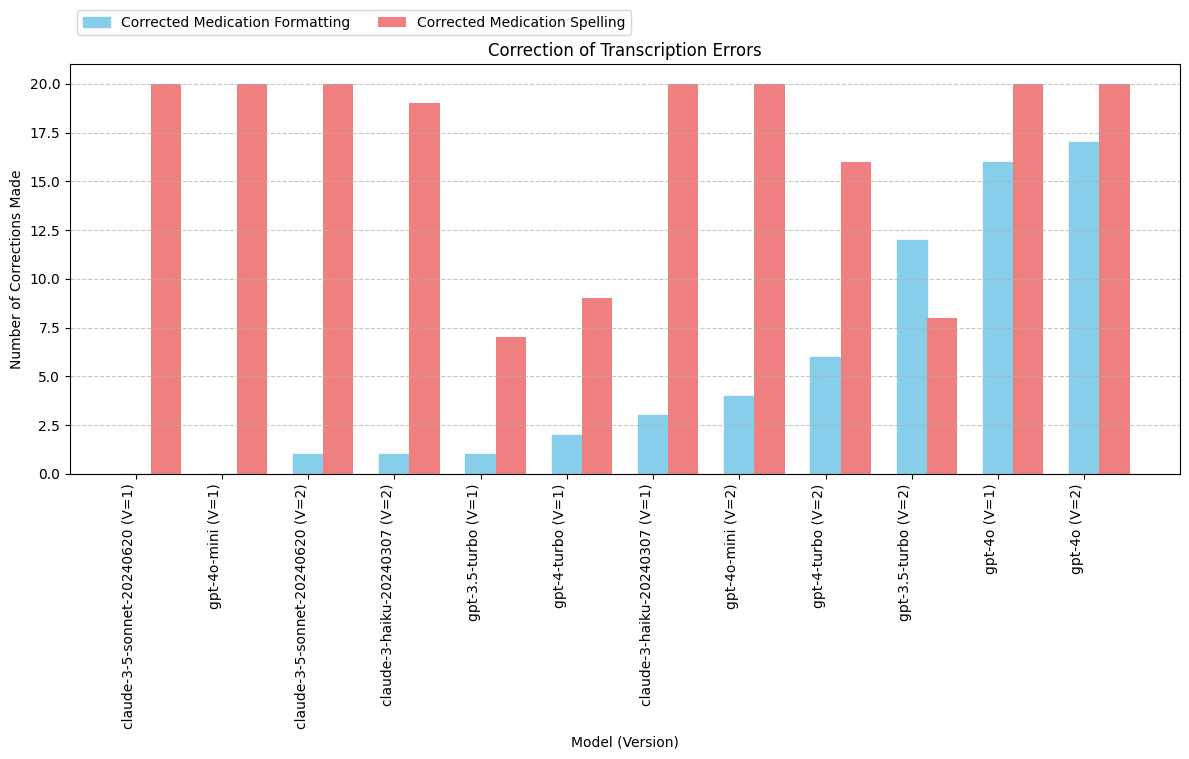

In [64]:

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 8))

bar_width = 0.35
opacity = 0.8

# Bar chart for total corrected values
bar1 = ax1.bar(grouped_output['model'], grouped_output['total_formatted'], width=bar_width, label='Corrected Medication Formatting', color='skyblue', edgecolor='skyblue')
bar2 = ax1.bar([x + bar_width for x in range(len(grouped_output['model']))], grouped_output['total_spelling'], width=bar_width, label='Corrected Medication Spelling', color='lightcoral')

# Customizing the plot
ax1.set_xlabel('Model (Version)')
ax1.set_ylabel('Number of Corrections Made')
ax1.set_title('Correction of Transcription Errors')
ax1.set_xticks(range(len(grouped_output['model'])))
ax1.set_xticklabels(grouped_output['model'], rotation=90, ha='right')
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.15), ncol=2)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

**Conclusions: Fixing Transcription Errore**

- claude-3-haiku got worse at catching errors, all other models improved at error catching with the updated prompt.

- gpt-4o appears to be most capable at catching prescription medicine spelling and formatting errors.

- Updated system prompt and JSON schema improve fixing medication transcription errors but errors are still present, especially with formatting. Spelling appears easier to catch than formatting. Consider supplying prompt with examples of correct medication formatting.



## **CONCLUSIONS**

To answer "What is the best model?" you need to identify the most important outcomes for this use-case.

You also need to understand how your *prompt* is impacting model performance.



#### Outcomes not impacted by prompt:


**Quick, consistent prediction times:**
- claude-3-haiku
- gpt-3.5-turbo

**Lowest cost:**
- gpt-4o-mini
- gpt-3.5-turbo
- claude-3-haiku


#### Outcomes impacted by prompt:

**Fixing transcription errors:**
- gpt-4o

**Inclusion of Differential Diagnosis and alternative treatment as requested:**
- claude-3.5-sonnet (long, very thorough)
- gpt-4o-mini

Consider that **improving the prompt can change model ranking**. In this case, if I want to select gpt-4o-mini because of the low cost and performance on Differential Diagnosis section but I am still concerned about the poor performance on fixing transcription errors, I could consider passing a dictionary of common perscription medicine names and more thorough formatting instructions.

If I want to increase the length of the Differential Diagnosis, I could use the outputs from claude-3.5-sonnet as an example.

Takeaways:
- **Doing "evals" is not simply a choice between manual human review or using an AI to grade outputs.** There is a third way. Identify opportunities for data analysis to be used in prompt and model evals.
- Improving the prompt can change model rankings. Use prompt improvement (system prompt + JSON schema) to pass desired traits from one model into another model. **Fully optimize the prompt before trying to determine the "best model."**

